<h3>Load helper functions</h3>

In [2]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code></h3>

In [3]:
gk_issues = load_gk_issues_for_analysis()
non_gk_issues = load_non_gk_issues_for_analysis()

<h2><b>Code Changes</b></h2>

In [4]:
# commits = load_commits()
commits = load_bens_collected_commits()
commit_to_gkir_rel = commits[['commit_sha', 'issue_id', 'repo_name']].copy()
commit_to_gkir_rel = commit_to_gkir_rel.drop_duplicates()
commits = commits.drop(columns=['issue_id', 'repo_name'])
commits = commits.drop_duplicates()

ngkir_commits = load_ngkir_commits()
commit_to_ngkir_rel = load_commit_event_relationships()
commit_to_ngkir_rel = (
    commit_to_ngkir_rel[
        commit_to_ngkir_rel['commit_sha'].isin(ngkir_commits['commit_sha'])
    ]
)
commit_to_ngkir_rel = commit_to_ngkir_rel.drop(columns=['commit_url'])
ngkir_commits = ngkir_commits.merge(
    commit_to_ngkir_rel[['commit_sha', 'event_type']],
    on='commit_sha'
)
ngkir_commits = ngkir_commits[ngkir_commits['event_type'] == 'referenced']
ngkir_commits.drop(columns=['event_type'])
print(f"{commits['commit_sha'].nunique()} GKIR commits")
print(f"{ngkir_commits['commit_sha'].nunique()} non-GKIR commits")

def extract_short_file_name(row):
    if row['file_name'].rfind('/') < 0:
        return row['file_name']
    return f".../{row['file_name'][row['file_name'].rfind('/')+1:]}"

def extract_only_file_name(row):
    if row['file_name'].rfind('/') < 0:
        return row['file_name']
    return f"{row['file_name'][row['file_name'].rfind('/')+1:]}"

commits['short_file_name'] = commits.apply(extract_short_file_name, axis=1).astype('category')
commits['only_file_name'] = commits.apply(extract_only_file_name, axis=1).astype('category')

ngkir_commits['short_file_name'] = ngkir_commits.apply(extract_short_file_name, axis=1).astype('category')
ngkir_commits['only_file_name'] = ngkir_commits.apply(extract_only_file_name, axis=1).astype('category')

2044 GKIR commits
88386 non-GKIR commits


In [5]:
count = (
    commit_to_gkir_rel[
        commit_to_gkir_rel['repo_name'].isin(
            commit_to_ngkir_rel['repo_name']
        )
    ]['repo_name'].nunique()
)
print(f"Out of {commit_to_gkir_rel['repo_name'].nunique()} repos with GKIR commits, we have collected commits on non-GKIR issues from {count} of those repos")

Out of 779 repos with GKIR commits, we have collected commits on non-GKIR issues from 617 of those repos


<h3>Helper functions for filtering commits</h3>

In [6]:
deps_spec_files = ['package.json', 'package-lock.json', 'yarn.lock', '.../package.json', '.../package-lock.json']
package_json = ['package.json']

def commit_changes_file(commit_changes, list_of_files):    
    commit_changes_for_list_of_files = (
        commit_changes[
            commit_changes['only_file_name'].isin(list_of_files)
        ]
    )
    return len(commit_changes_for_list_of_files) > 0

def commit_only_changes_files(commit_changes, list_of_files):
    count_of_file_changes = len(commit_changes)
    count_of_changes_that_change_list_of_files = (
        len(
            commit_changes[
                commit_changes['only_file_name'].isin(list_of_files)
            ]
        )
    )
    return count_of_file_changes == count_of_changes_that_change_list_of_files


<h3>How often do GKIR commits change dependency files?</h3>

In [7]:
commit_count = commits['commit_sha'].nunique()

changes_package_json = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, list_of_files=package_json))
)
changes_package_json_count = changes_package_json['commit_sha'].nunique()
print(f'{calculate_percent(changes_package_json_count, commit_count)}% of commits change the package.json file')

changes_dep_files = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, deps_spec_files))
)
changes_dep_file_count = changes_dep_files['commit_sha'].nunique()
print(f'{calculate_percent(changes_dep_file_count, commit_count)}% of commits change at least 1 dependency specification file')


changes_dep_files_only = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_only_changes_files(group, deps_spec_files))
)
changes_dep_file_only_count = changes_dep_files_only['commit_sha'].nunique()
print(f'{calculate_percent(changes_dep_file_only_count, commit_count)}% of commits change only dependency specification files')



77.74% of commits change the package.json file
82.49% of commits change at least 1 dependency specification file
55.87% of commits change only dependency specification files


<h3>What proportion change src code as well as a dependency file?</h3>

In [8]:
# Get commits that change dep files
# Group by commit, loop over, and count occurrences of non-dep files
commits_that_change_dep_files = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, deps_spec_files))
)

files_changed_with_dep_files = (
    commits_that_change_dep_files[
        ~commits_that_change_dep_files['only_file_name'].isin(deps_spec_files)
    ]
)

commits_that_change_dep_file_and_other_files__count = files_changed_with_dep_files['commit_sha'].nunique()
prop = calculate_percent(commits_that_change_dep_file_and_other_files__count, commit_count)
print(f'{prop}% of commits change a dependency specification file and another source file')


files_changed_with_dep_files['file_name'].value_counts().head(10)

# files_changed_with_dep_files.groupby('commit_sha')['file_name'].value_counts()
# file_counts = dict()
# def record_file_counts(list_of_files):
#     for f in list_of_files:
#         if not f in file_counts:
#             file_counts[f] = 0
#         file_counts[f] += 1
# commits_that_change_dep_files.groupby('commit_sha')['file_name'].unique().apply(record_file_counts)

# count_of_file_changes = (
#     pd.DataFrame({
#         'file_name': file_counts.keys(),
#         'count': file_counts.values(),
#     })
# )
# count_of_file_changes['proportion'] = count_of_file_changes['count'] / gk_commits['commit_sha'].nunique()
# count_of_file_changes = count_of_file_changes.sort_values('proportion', ascending=False)



26.61% of commits change a dependency specification file and another source file


.travis.yml                                                                                   62
packages/gulp-project-generator/src/generatePackageJson.js                                    44
README.md                                                                                     37
packages/gulp-project-generator/test/fixtures/expected/package-conventional-changelog.json    36
.eslintrc.json                                                                                27
CHANGELOG.md                                                                                  26
index.js                                                                                      25
.gitignore                                                                                    24
appveyor.yml                                                                                  16
shrinkwrap.yaml                                                                               14
Name: file_name, dtype: int64

<h2>Comparison with non-GKIR</h2>

<h3>Intra-project</h3>

In [9]:
# Get commit_to_gkir_rel rows for commits that don't only change dependency files
changes_dep_files_only = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_only_changes_files(group, deps_spec_files))
)

gkir_changes_other_files = (
    commits[
        ~commits['commit_sha'].isin(
            changes_dep_files_only['commit_sha'].unique()
        )
    ]
)

shas =  gkir_changes_other_files['commit_sha'].unique()
commit_to_gkir_rel__commit_changes_other_files = (
    commit_to_gkir_rel[
        commit_to_gkir_rel['commit_sha'].isin(
            shas
        )
    ]
)

gkirs_w_referenced_commit = (
    gk_issues[
        gk_issues['id'].isin(
            commit_to_gkir_rel__commit_changes_other_files['issue_id']
        )
    ].copy()
)
ngkirs_for_matching_projects = (
    non_gk_issues[
        non_gk_issues['repo_name'].isin(
            gkirs_w_referenced_commit['repo_name']
        )
    ]
)
ngkirs_for_matching_projects_w_referenced_commit = (
    ngkirs_for_matching_projects[
        ngkirs_for_matching_projects['id'].isin(
            commit_to_ngkir_rel['issue_id']
        )
    ]
)

# For every gkir with a referenced commit
# Get the closest non-gkir in the same project with a referenced commit
def get_previous_ngkir_id_w_referenced_commit(gkir):
    repo_ngkirs = (
        ngkirs_for_matching_projects_w_referenced_commit[
            ngkirs_for_matching_projects_w_referenced_commit['repo_name'] == gkir['repo_name']
        ]
    )
    if len(repo_ngkirs) == 0:
        return pd.NA
    col = 'created_at'
    ngkirs_closed_before_gkir = (
        repo_ngkirs[
            repo_ngkirs[col] < gkir[col]
        ]
    )
    closest_at_top = (
        ngkirs_closed_before_gkir
            .sort_values(by=col, ascending=False)
    )
    if len(closest_at_top) == 0:
        ngkirs_closed_after_gkir = (
            repo_ngkirs[
                repo_ngkirs[col] > gkir[col]
            ]
        )
        closest_at_top = (
            ngkirs_closed_before_gkir
                .sort_values(by=col, ascending=True)
        )
    if len(closest_at_top) == 0:
        return pd.NA
    ngkir_closest_to_gkir = closest_at_top.iloc[0]
    return ngkir_closest_to_gkir['id']
        
gkirs_w_referenced_commit['closest_ngkir_id'] = (
    gkirs_w_referenced_commit.apply(
        get_previous_ngkir_id_w_referenced_commit,
        axis=1
    )
)

In [10]:
# Get commits referenced from gkirs
gkir_referenced_commit_rels = (
    commit_to_gkir_rel[
        commit_to_gkir_rel['issue_id'].isin(
            gkirs_w_referenced_commit['id']
        )
    ]
)
gkir_referenced_commits = (
    commits[
        commits['commit_sha'].isin(
            gkir_referenced_commit_rels['commit_sha'].unique()
        )
    ]
)
gkir_referenced_commits['commit_sha'].nunique()

# Get commits referenced from non-gkirs
ngkir_referenced_commit_rels = (
    commit_to_ngkir_rel[
        commit_to_ngkir_rel['issue_id'].isin(
            gkirs_w_referenced_commit['closest_ngkir_id']
        )
    ]
)
ngkir_referenced_commits = (
    ngkir_commits[
        ngkir_commits['commit_sha'].isin(
            ngkir_referenced_commit_rels['commit_sha'].unique()
        )
    ]
)

print(f"For matching GKIR commits and their closest non-GKIR commit (changing more than dep spec files)...")
print(f"{gkir_referenced_commits['commit_sha'].nunique()} GKIR commits...")
print(f"{ngkir_referenced_commits['commit_sha'].nunique()} non-GKIR commits...")

For matching GKIR commits and their closest non-GKIR commit (changing more than dep spec files)...
948 GKIR commits...
348 non-GKIR commits...


In [11]:
gkir_referenced_commits[
    gkir_referenced_commits['commit_sha'].isin(ngkir_referenced_commits['commit_sha'])
]['commit_sha'].nunique()

9

<h3>How many files do these commits change?</h3>

Saving figure number_of_files_changed_per_commit


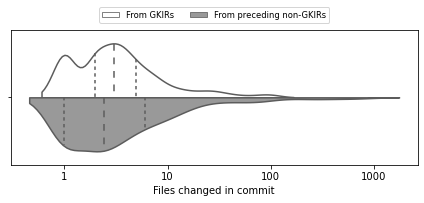

	Mann-Whitney: statistic=159381.5 pvalue=0.17203508957636582
	Cliff'a Delta: delta=0.03377043018575101 size=negligible
    
GKIR number of files changed      Count    Mean     STD    Min    25%    Median    75%    Max
------------------------------  -------  ------  ------  -----  -----  --------  -----  -----
files_changed                       948   6.507  13.465      1      2         3      5    100

GKIR number of files changed      Count    Mean     STD    Min    25%    Median    75%    Max
------------------------------  -------  ------  ------  -----  -----  --------  -----  -----
files_changed                       348  15.126  66.651      1      1       2.5      6    800



In [12]:
gkir_number_of_file_changes = (
    gkir_referenced_commits
        .groupby('commit_sha')['file_name']
        .count()
        .to_frame(name='files_changed')
        .reset_index()
)
gkir_number_of_file_changes['type'] = 'gkir'
ngkir_number_of_file_changes = (
    ngkir_referenced_commits
        .groupby('commit_sha')['file_name']
        .count()
        .to_frame(name='files_changed')
        .reset_index()
)
ngkir_number_of_file_changes['type'] = 'non-gkir'

number_of_file_changes = gkir_number_of_file_changes.append(ngkir_number_of_file_changes)
number_of_file_changes['log_files_changed'] = np.log10(number_of_file_changes['files_changed'])
number_of_file_changes['placeholder'] = ''

for_plot = number_of_file_changes.copy()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
sns.violinplot(
    data=for_plot,
    x='log_files_changed',
    y='placeholder',
    hue='type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
    scale='width',
)
ax.set_xlabel('Files changed in commit')
ax.set_ylabel('')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
# ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2
)

L.get_texts()[0].set_text('From GKIRs')
L.get_texts()[1].set_text('From preceding non-GKIRs')

save_fig('number_of_files_changed_per_commit')

plt.show()

mannwhitneyu_cliffsdelta(
    number_of_file_changes[number_of_file_changes['type'] == 'gkir']['files_changed'],
    number_of_file_changes[number_of_file_changes['type'] == 'non-gkir']['files_changed']
)

tfns(
    gkir_number_of_file_changes,
    ['files_changed'],
    title='GKIR number of files changed'
)
tfns(
    ngkir_number_of_file_changes,
    ['files_changed'],
    title='GKIR number of files changed'
)

<h3>Size of these commits change?</h3>

Saving figure size_of_commits


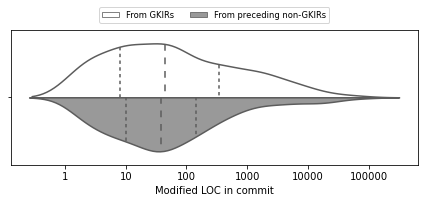

	Mann-Whitney: statistic=158395.5 pvalue=0.13604976600623425
	Cliff'a Delta: delta=0.039747926669576605 size=negligible
    
GKIR size of changes      Count     Mean     STD    Min    25%    Median    75%    Max
----------------------  -------  -------  ------  -----  -----  --------  -----  -----
stats_total                 948  1251.19  5613.8      1      8      44.5  345.5  81555

Non-GKIR size of changes      Count     Mean      STD    Min    25%    Median     75%    Max
--------------------------  -------  -------  -------  -----  -----  --------  ------  -----
stats_total                     348  1143.59  5938.86      1     10        38  145.25  81555



In [13]:
gkir_size_of_changes = (
    gkir_referenced_commits
        .groupby('commit_sha')['stats_total']
        .first()
        .to_frame(name='stats_total')
        .reset_index()
)
gkir_size_of_changes['type'] = 'gkir'
ngkir_size_of_changes = (
    ngkir_referenced_commits
        .groupby('commit_sha')['stats_total']
        .first()
        .to_frame(name='stats_total')
        .reset_index()
)
ngkir_size_of_changes['type'] = 'non-gkir'
size_of_changes = gkir_size_of_changes.append(ngkir_size_of_changes)
size_of_changes['stats_total'].describe()

size_of_changes['log_stats_total'] = np.log10(size_of_changes['stats_total'])
size_of_changes['placeholder'] = ''

for_plot = size_of_changes.copy()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
sns.violinplot(
    data=for_plot,
    x='log_stats_total',
    y='placeholder',
    hue='type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
    scale='width',
)
ax.set_xlabel('Modified LOC in commit')
ax.set_ylabel('')
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels([1, 10, 100, 1000, 10000, 100000])
# ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2
)

L.get_texts()[0].set_text('From GKIRs')
L.get_texts()[1].set_text('From preceding non-GKIRs')

save_fig('size_of_commits')

plt.show()

mannwhitneyu_cliffsdelta(
    size_of_changes[size_of_changes['type'] == 'gkir']['stats_total'],
    size_of_changes[size_of_changes['type'] == 'non-gkir']['stats_total']
)

tfns(
    gkir_size_of_changes,
    ['stats_total'],
    title='GKIR size of changes'
)
tfns(
    ngkir_size_of_changes,
    ['stats_total'],
    title='Non-GKIR size of changes'
)

## Where are these changes happening?

Saving figure most_common_file_changes


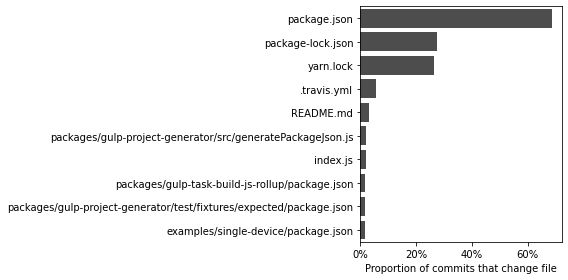

In [18]:
file_counts = dict()
def record_file_counts(list_of_files):
    for f in list_of_files:
        if not f in file_counts:
            file_counts[f] = 0
        file_counts[f] += 1
commits.groupby('commit_sha')['file_name'].unique().apply(record_file_counts)

count_of_file_changes = (
    pd.DataFrame({
        'file_name': file_counts.keys(),
        'count': file_counts.values(),
    })
)

count_of_file_changes['proportion'] = count_of_file_changes['count'] / commits['commit_sha'].nunique()
count_of_file_changes = count_of_file_changes.sort_values('proportion', ascending=False)

UNIQUE_FILE_LIMIT = 10
most_common_files = count_of_file_changes.head(UNIQUE_FILE_LIMIT).reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
sns.barplot(
    data=most_common_files,
    y='file_name',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of commits that change file')
ax.set_ylabel('')
ax.xaxis.set_major_formatter(proportion_func_formatter)

save_fig('most_common_file_changes')
plt.show()

In [19]:
most_common_files

,index,file_name,count,proportion
0,0,package.json,1404,0.686888
1,69,package-lock.json,558,0.272994
2,68,yarn.lock,540,0.264188
3,95,.travis.yml,118,0.057730
4,188,README.md,61,0.029843
5,141,packages/gulp-project-generator/src/generatePackageJson.js,44,0.021526
6,92,index.js,39,0.019080
7,163,packages/gulp-task-build-js-rollup/package.json,37,0.018102
8,143,packages/gulp-project-generator/test/fixtures/expected/package.json,37,0.018102
9,140,examples/single-device/package.json,37,0.018102


Saving figure most_common_non_deps_file_changes


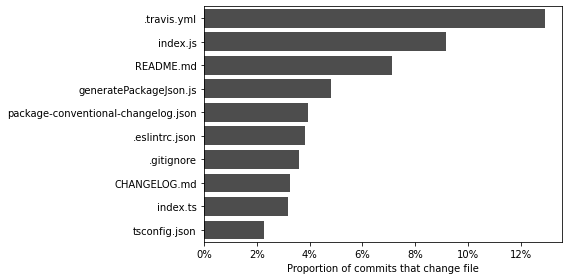

In [29]:
deps_spec_files = ['package.json', 'package-lock.json', 'yarn.lock', '.../package.json', '.../package-lock.json']

not_deps_commits = commits[~commits['short_file_name'].isin(deps_spec_files)]
not_deps_commits[['short_file_name', 'only_file_name']].value_counts()

file_counts = dict()
def record_file_counts(list_of_files):
    for f in list_of_files:
        if not f in file_counts:
            file_counts[f] = 0
        file_counts[f] += 1
not_deps_commits.groupby('commit_sha')['only_file_name'].unique().apply(record_file_counts)

count_of_file_changes = (
    pd.DataFrame({
        'file_name': file_counts.keys(),
        'count': file_counts.values(),
    })
)

count_of_file_changes['proportion'] = count_of_file_changes['count'] / not_deps_commits['commit_sha'].nunique()
count_of_file_changes = count_of_file_changes.sort_values('proportion', ascending=False)

UNIQUE_FILE_LIMIT = 10
most_common_files = count_of_file_changes.head(UNIQUE_FILE_LIMIT).reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
sns.barplot(
    data=most_common_files,
    y='file_name',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of commits that change file')
ax.set_ylabel('')
ax.xaxis.set_major_formatter(proportion_func_formatter)

save_fig('most_common_non_deps_file_changes')
plt.show()


## File extentions

In [84]:
count_of_file_changes_categorized = count_of_file_changes.copy()

def extract_file_extention(file_name):
    idx = file_name.rfind('.')
    if idx < 0:
        return pd.NA
    return file_name[idx:]
count_of_file_changes_categorized['file_extention'] = count_of_file_changes_categorized.apply(lambda row: extract_file_extention(row['file_name']), axis=1)

In [100]:
file_extention_counts = (
    count_of_file_changes_categorized
        .groupby('file_extention')
        .size()
        .to_frame(name='count')
        .sort_values('count', ascending=False)
)
file_extention_counts['proportion'] = file_extention_counts['count'] / file_extention_counts['count'].sum()

file_extention_counts.head(10)

,count,proportion
file_extention,,
.js,745,0.342057
.ts,446,0.204775
.html,270,0.123967
.json,98,0.044995
.py,95,0.043618
.tsx,93,0.042700
.png,65,0.029844
.snap,38,0.017447
.scss,36,0.016529


In [77]:
count_of_file_changes_categorized = count_of_file_changes.copy()
count_of_file_changes_categorized['type'] = 'other'

# count_of_file_changes_categorized[count_of_file_changes_categorized['file_name'] == '']

# count_of_file_changes_categorized[count_of_file_changes_categorized['file_name'].str.contains('*.ts', regex=True)]

source_files_regex = '|'.join([
    '.js',
    '.ts',
    '.html',
    '.css',
    '.py',
    '.vue',
    '.graphql',
    '.coffee'
])
count_of_file_changes_categorized.loc[
    count_of_file_changes_categorized['file_name'].str.contains(source_files_regex),
    'type'
] = 'source'

config_files_regex = '|'.join([
    '.yml',
    '.yaml',
    '.json',
    '.eslintrc',
    '.lock',
    '.npmignore',
    'gitignore'
])
count_of_file_changes_categorized.loc[
    count_of_file_changes_categorized['file_name'].str.contains(config_files_regex),
    'type'
] = 'config'

markdown_files_regex = '|'.join([
    '.md',
])
count_of_file_changes_categorized.loc[
    count_of_file_changes_categorized['file_name'].str.contains(markdown_files_regex),
    'type'
] = 'markdown'

image_files_regex = '|'.join([
    '.png',
    '.jpg',
    '.svg',
])
count_of_file_changes_categorized.loc[
    count_of_file_changes_categorized['file_name'].str.contains(image_files_regex),
    'type'
] = 'image'

count_of_file_changes_categorized['type'].value_counts()
# count_of_file_changes_categorized[pd.isna(count_of_file_changes_categorized['type'])]

source      1792
config       136
other        121
image        101
markdown      41
Name: type, dtype: int64

In [80]:
count_of_file_changes_categorized[count_of_file_changes_categorized['type'] == 'other'].value_counts()

file_name                        count  proportion  type 
.DS_Store                        3      0.003279    other    1
compatibility.asciidoc           5      0.005464    other    1
hapi.asciidoc                    1      0.001093    other    1
handlebars_0.patch               1      0.001093    other    1
google-apps-script+0.0.37.patch  2      0.002186    other    1
                                                            ..
Nunitosanslight.woff             1      0.001093    other    1
LICENSE                          2      0.002186    other    1
Dockerfile.test-pea              1      0.001093    other    1
Dockerfile.arm                   1      0.001093    other    1
virtualservice.puml              2      0.002186    other    1
Length: 121, dtype: int64

## Compare commit sizes by file extention

In [ ]:
deps_spec_files = ['package.json', 'package-lock.json', 'yarn.lock', '.../package.json', '.../package-lock.json']
def extract_file_extention(file_name):
    idx = file_name.rfind('.')
    if idx < 0:
        return pd.NA
    return file_name[idx:]

In [168]:
not_deps_commits = commits[~commits['short_file_name'].isin(deps_spec_files)].copy()
# not_deps_commits = commits.copy()
not_deps_commits['file_extention'] = not_deps_commits.apply(lambda row: extract_file_extention(row['only_file_name']), axis=1)
not_deps_commits.loc[
    not_deps_commits['file_extention'] == '.yaml',
    'file_extention'
] = '.yml'
not_deps_commits.loc[
    not_deps_commits['file_extention'] == '.tsx',
    'file_extention'
] = '.ts'

In [189]:
not_deps_commits_ngkir = ngkir_commits[~ngkir_commits['short_file_name'].isin(deps_spec_files)].copy()
# not_deps_commits = commits.copy()
not_deps_commits_ngkir['file_extention'] = not_deps_commits_ngkir.apply(lambda row: extract_file_extention(row['only_file_name']), axis=1)
not_deps_commits_ngkir.loc[
    not_deps_commits_ngkir['file_extention'] == '.yaml',
    'file_extention'
] = '.yml'
not_deps_commits_ngkir.loc[
    not_deps_commits_ngkir['file_extention'] == '.tsx',
    'file_extention'
] = '.ts'

In [177]:
not_deps_commits[not_deps_commits['file_extention'] == '.json']['file_name']

150      app/templates/_package.json
152      app/templates/_package.json
228                   .eslintrc.json
230              test/.eslintrc.json
279                   .eslintrc.json
                    ...             
12953               jest.config.json
12955            npm-shrinkwrap.json
12962                 .eslintrc.json
12972               jest.config.json
12974            npm-shrinkwrap.json
Name: file_name, Length: 457, dtype: object

In [190]:
temp_gkir = not_deps_commits.groupby(['commit_sha', 'file_extention'])['file_changes'].median().to_frame().reset_index()
temp_ngkir = not_deps_commits_ngkir.groupby(['commit_sha', 'file_extention'])['file_changes'].median().to_frame().reset_index()

In [191]:
most_common_files_changed_gkir = (
    temp_gkir['file_extention']
        .value_counts()
        .head(10)
        .to_frame(name='count')
        .rename_axis('file_extention')
        .reset_index()
)
most_common_files_changed_gkir['proportion'] = most_common_files_changed_gkir['count'] / not_deps_commits['commit_sha'].nunique()

most_common_files_changed_ngkir = (
    temp_ngkir['file_extention']
        .value_counts()
        .head(10)
        .to_frame(name='count')
        .rename_axis('file_extention')
        .reset_index()
)
most_common_files_changed_ngkir['proportion'] = most_common_files_changed_ngkir['count'] / not_deps_commits_ngkir['commit_sha'].nunique()

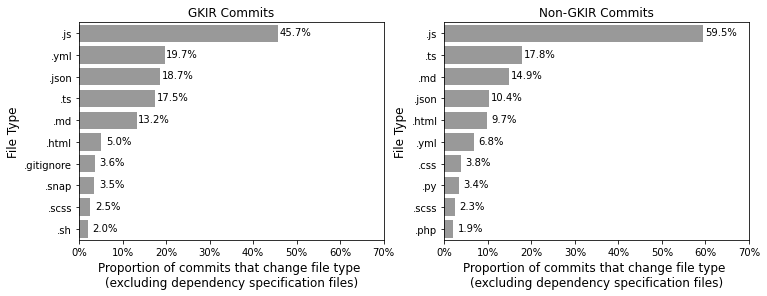

In [202]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.barplot(
    data=most_common_files_changed_gkir,
    y='file_extention',
    x='proportion',
    color="0.6",
    ax=ax1
)
ax1.set_xlim(0, 0.7)
ax1.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax1.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])
ax1.set_xlabel('Proportion of commits that change file type \n(excluding dependency specification files)', fontsize=12)
ax1.set_ylabel('File Type', fontsize=12)
ax1.set_title('GKIR Commits')

sns.barplot(
    data=most_common_files_changed_ngkir,
    y='file_extention',
    x='proportion',
    color="0.6",
    ax=ax2
)
ax2.set_xlim(0, 0.7)
ax2.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax2.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])
ax2.set_xlabel('Proportion of commits that change file type \n(excluding dependency specification files)', fontsize=12)
ax2.set_ylabel('File Type', fontsize=12)
ax2.set_title('Non-GKIR Commits')


format_text = lambda x: f'{round(x*100, 1)}%'
show_values_on_bars(ax1, h_v='h', h_offset=0.04, v_offset=0.08, val_formatter=format_text)
show_values_on_bars(ax2, h_v='h', h_offset=0.04, v_offset=0.08, val_formatter=format_text)

save_fig('most_common_non_deps_file_extention_changes')
plt.show()

Saving figure most_common_non_deps_file_extention_changes_gkir


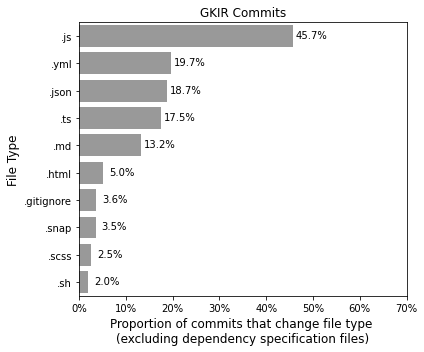

In [210]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

sns.barplot(
    data=most_common_files_changed_gkir,
    y='file_extention',
    x='proportion',
    color="0.6",
    ax=ax1
)
ax1.set_xlim(0, 0.7)
ax1.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax1.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])
ax1.set_xlabel('Proportion of commits that change file type \n(excluding dependency specification files)', fontsize=12)
ax1.set_ylabel('File Type', fontsize=12)
ax1.set_title('GKIR Commits')

format_text = lambda x: f'{round(x*100, 1)}%'
show_values_on_bars(ax1, h_v='h', h_offset=0.04, v_offset=0.08, val_formatter=format_text)

save_fig('most_common_non_deps_file_extention_changes_gkir')
plt.show()

Saving figure most_common_non_deps_file_extention_changes_non_gkir


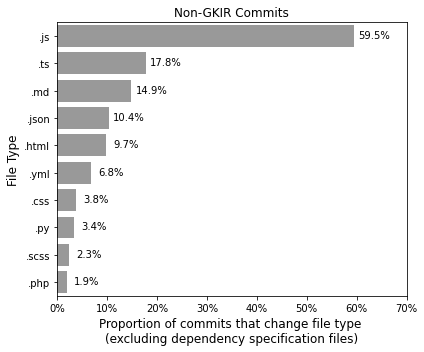

In [209]:
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

sns.barplot(
    data=most_common_files_changed_ngkir,
    y='file_extention',
    x='proportion',
    color="0.6",
    ax=ax2
)
ax2.set_xlim(0, 0.7)
ax2.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax2.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])
ax2.set_xlabel('Proportion of commits that change file type \n(excluding dependency specification files)', fontsize=12)
ax2.set_ylabel('File Type', fontsize=12)
ax2.set_title('Non-GKIR Commits')

format_text = lambda x: f'{round(x*100, 1)}%'
show_values_on_bars(ax2, h_v='h', h_offset=0.04, v_offset=0.08, val_formatter=format_text)

save_fig('most_common_non_deps_file_extention_changes_non_gkir')
plt.show()

In [149]:
common_file_changes = temp[temp['file_extention'].isin(most_common_files_changed['file_extention'])]
common_file_changes_grouped = common_file_changes.groupby('file_extention')['file_changes']
common_file_changes_grouped.describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
file_extention,,,,,,,,
.js,418.0,23.424641,68.911264,0.0,2.00,6.0,17.000,913.5
.yml,180.0,32.283333,138.518993,1.0,2.00,3.0,7.625,1209.0
.json,171.0,567.426901,5856.268887,0.0,2.00,4.0,14.000,76186.0
.ts,160.0,11.843750,17.845968,1.0,2.00,6.0,14.250,164.5
.md,121.0,22.210744,50.521808,1.0,3.00,6.0,16.000,376.0
.html,46.0,113.250000,634.163454,1.0,3.00,9.0,26.375,4317.0
.gitignore,33.0,3.393939,5.367375,1.0,1.00,2.0,3.000,32.0
.snap,32.0,67.640625,255.193862,0.0,2.00,3.5,22.000,1437.0
.scss,23.0,8.826087,5.556750,0.0,3.50,7.0,14.000,17.0


<h3>Just compare across all issue reports</h3>

In [10]:
gkir_commits_that_change_dep_files_only = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_only_changes_files(group, deps_spec_files))
)
gkir_shas_that_change_dep_files_only = gkir_commits_that_change_dep_files_only['commit_sha'].unique()
gkir_commits_that_change_other_files = (
    commits[
        ~commits['commit_sha'].isin(gkir_shas_that_change_dep_files_only)
    ]
)
print(f"{gkir_commits_that_change_other_files['commit_sha'].nunique()} GKIR commits that change other files")

ngkir_commits_that_change_dep_files_only = (
    ngkir_commits
        .groupby('commit_sha')
        .filter(lambda group: commit_only_changes_files(group, deps_spec_files))
)
ngkir_shas_that_change_dep_files_only = ngkir_commits_that_change_dep_files_only['commit_sha'].unique()
ngkir_commits_that_change_other_files = (
    ngkir_commits[
        ~ngkir_commits['commit_sha'].isin(ngkir_shas_that_change_dep_files_only)
    ]
)
print(f"{ngkir_commits_that_change_other_files['commit_sha'].nunique()} non-GKIR commits that change other files")


902 GKIR commits that change other files
85181 non-GKIR commits that change other files


In [11]:
gkir_prop = calculate_percent(
    gkir_commits_that_change_dep_files_only['commit_sha'].nunique(),
    commits['commit_sha'].nunique()
)
ngkir_prop = calculate_percent(
    ngkir_commits_that_change_dep_files_only['commit_sha'].nunique(),
    ngkir_commits['commit_sha'].nunique()
)

print(f"To recap:")
print(f"{gkir_prop}% of commits referenced from GKIRs only change dependency specification files")
print(f"{ngkir_prop}% of commits referenced from non-GKIRs only change dependency specification files")

To recap:
55.87% of commits referenced from GKIRs only change dependency specification files
3.63% of commits referenced from non-GKIRs only change dependency specification files


In [20]:
gkir_commits_that_change_package_json = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, ['package.json']))
)
gkir_prop = calculate_percent(
    gkir_commits_that_change_package_json['commit_sha'].nunique(),
    commits['commit_sha'].nunique()
)

ngkir_commits_that_change_package_json = (
    ngkir_commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, ['package.json']))
)
ngkir_prop = calculate_percent(
    ngkir_commits_that_change_package_json['commit_sha'].nunique(),
    ngkir_commits['commit_sha'].nunique()
)

print(f'{gkir_prop}% of commits referenced from GKIRs change package.json file')
print(f'{ngkir_prop}% of commits referenced from non-GKIRs change package.json file')


77.74% of commits referenced from GKIRs change package.json file
17.44% of commits referenced from non-GKIRs change package.json file


In [21]:
gkir_commits_that_change_package_lock_json = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, ['package-lock.json']))
)
gkir_prop = calculate_percent(
    gkir_commits_that_change_package_lock_json['commit_sha'].nunique(),
    commits['commit_sha'].nunique()
)

ngkir_commits_that_change_package_lock_json = (
    ngkir_commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, ['package-lock.json']))
)
ngkir_prop = calculate_percent(
    ngkir_commits_that_change_package_lock_json['commit_sha'].nunique(),
    ngkir_commits['commit_sha'].nunique()
)

print(f'{gkir_prop}% of commits referenced from GKIRs change package-lock.json file')
print(f'{ngkir_prop}% of commits referenced from non-GKIRs change package-lock.json file')

28.28% of commits referenced from GKIRs change package-lock.json file
3.81% of commits referenced from non-GKIRs change package-lock.json file


In [22]:
gkir_commits_that_change_yarn_lock = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, ['yarn.lock']))
)
gkir_prop = calculate_percent(
    gkir_commits_that_change_yarn_lock['commit_sha'].nunique(),
    commits['commit_sha'].nunique()
)

ngkir_commits_that_change_yarn_lock = (
    ngkir_commits
        .groupby('commit_sha')
        .filter(lambda group: commit_changes_file(group, ['yarn.lock']))
)
ngkir_prop = calculate_percent(
    ngkir_commits_that_change_yarn_lock['commit_sha'].nunique(),
    ngkir_commits['commit_sha'].nunique()
)

print(f'{gkir_prop}% of commits referenced from GKIRs change yarn.lock file')
print(f'{ngkir_prop}% of commits referenced from non-GKIRs change yarn.lock file')

26.96% of commits referenced from GKIRs change yarn.lock file
2.94% of commits referenced from non-GKIRs change yarn.lock file


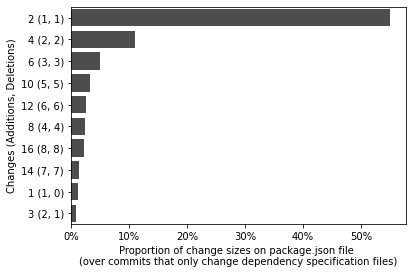

GKIR referenced commits that only change deps files (package.json file changes)
0.5675675675675677% are one-line changes
0.7513513513513514% modify three or fewer lines


,file_changes,file_additions,file_deletions,proportion,label
0,2,1,1,0.549189,"2 (1, 1)"
1,4,2,2,0.110270,"4 (2, 2)"
2,6,3,3,0.050811,"6 (3, 3)"
3,10,5,5,0.032432,"10 (5, 5)"
4,12,6,6,0.025946,"12 (6, 6)"


In [13]:
gkir_commits_that_change_dep_files_only__packagejson = (
    gkir_commits_that_change_dep_files_only[
        gkir_commits_that_change_dep_files_only['file_name'] == 'package.json'
    ].groupby('commit_sha')
    .first()
    .reset_index()
)

grouped_by_file_changes = (
    gkir_commits_that_change_dep_files_only__packagejson
        .groupby(['file_changes', 'file_additions', 'file_deletions'])
        ['commit_sha']
)

for_plot = (
    (
        grouped_by_file_changes.count() /
        grouped_by_file_changes.count().sum()
    ).sort_values(ascending=False)
    .reset_index(name='proportion')
)

for_plot['label'] = for_plot.apply(
    lambda row: f"{int(row['file_changes'])} ({int(row['file_additions'])}, {int(row['file_deletions'])})",
    axis=1
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
sns.barplot(
    data=for_plot.head(10),
    y='label',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of change sizes on package.json file \n(over commits that only change dependency specification files)')
ax.set_ylabel('Changes (Additions, Deletions)')
ax.xaxis.set_major_formatter(proportion_func_formatter)
plt.show()

less_than_three_labels = [
    '1 (1, 0)',
    '1 (0, 1)',
    '2 (1, 1)',
    '2 (2, 0)',
    '2 (0, 2)',
    '3 (3, 0)',
    '3 (2, 1)',
    '3 (1, 2)',
    '3 (0, 3)',
    '4 (3, 1)',
    '4 (2, 2)',
    '4 (1, 3)',
    '6 (3, 3)',
]
prop_that_modify_one_line = (
    for_plot[
        for_plot['file_changes'] <= 2
    ]['proportion'].sum()
)
prop_that_modify_three_lines = (
    for_plot[
        for_plot['label'].isin(less_than_three_labels)
    ]['proportion'].sum()
)
print("GKIR referenced commits that only change deps files (package.json file changes)")

print(f"{prop_that_modify_one_line}% are one-line changes")
print(f"{prop_that_modify_three_lines}% modify three or fewer lines")

for_plot.head()

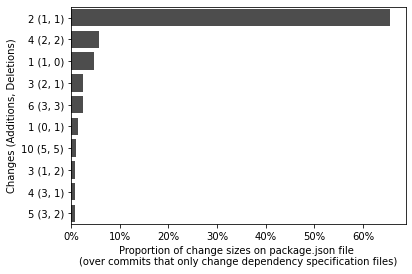

Non-GKIR referenced commits that only change deps files (package.json file changes)
0.7280453257790369% are one-line changes
0.8624038850667747% modify three or fewer lines


,file_changes,file_additions,file_deletions,proportion,label
0,2,1,1,0.654391,"2 (1, 1)"
1,4,2,2,0.057467,"4 (2, 2)"
2,1,1,0,0.048563,"1 (1, 0)"
3,3,2,1,0.025900,"3 (2, 1)"
4,6,3,3,0.024282,"6 (3, 3)"
5,1,0,1,0.015378,"1 (0, 1)"


In [14]:
ngkir_commits_that_change_dep_files_only__packagejson = (
    ngkir_commits_that_change_dep_files_only[
        ngkir_commits_that_change_dep_files_only['file_name'] == 'package.json'
    ].groupby('commit_sha')
    .first()
    .reset_index()
)

grouped_by_file_changes = (
    ngkir_commits_that_change_dep_files_only__packagejson
        .groupby(['file_changes', 'file_additions', 'file_deletions'])
        ['commit_sha']
)

for_plot = (
    (
        grouped_by_file_changes.count() /
        grouped_by_file_changes.count().sum()
    ).sort_values(ascending=False)
    .reset_index(name='proportion')
)

for_plot['label'] = for_plot.apply(
    lambda row: f"{int(row['file_changes'])} ({int(row['file_additions'])}, {int(row['file_deletions'])})",
    axis=1
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
sns.barplot(
    data=for_plot.head(10),
    y='label',
    x='proportion',
    color="0.3",
    ax=ax
)
ax.set_xlabel('Proportion of change sizes on package.json file \n(over commits that only change dependency specification files)')
ax.set_ylabel('Changes (Additions, Deletions)')
ax.xaxis.set_major_formatter(proportion_func_formatter)
# save_fig('')
plt.show()
less_than_three_labels = [
    '1 (1, 0)',
    '1 (0, 1)',
    '2 (1, 1)',
    '2 (2, 0)',
    '2 (0, 2)',
    '3 (3, 0)',
    '3 (2, 1)',
    '3 (1, 2)',
    '3 (0, 3)',
    '4 (3, 1)',
    '4 (2, 2)',
    '4 (1, 3)',
    '6 (3, 3)',
]
prop_that_modify_one_line = (
    for_plot[
        for_plot['file_changes'] <= 2
    ]['proportion'].sum()
)
prop_that_modify_three_lines = (
    for_plot[
        for_plot['label'].isin(less_than_three_labels)
    ]['proportion'].sum()
)

print("Non-GKIR referenced commits that only change deps files (package.json file changes)")
print(f"{prop_that_modify_one_line}% are one-line changes")

print(f"{prop_that_modify_three_lines}% modify three or fewer lines")
for_plot.head(6)

<h3>Types of changes made in package.json</h3>

In [15]:
import sys
!{sys.executable} -m pip install semver
import semver
import re

def extract_add_and_del_lines(patch):
    added_lines = list()
    deleted_lines = list()
    for l in patch.split('\n'):
        if len(l) < 1:
            continue
        change = l[0]
        l[1:].replace(' ', '')
        if change == '-':
            deleted_lines.append(l[1:].replace(' ', ''))
        if change == '+':
            added_lines.append(l[1:].replace(' ', ''))
    return added_lines, deleted_lines

def parse_dep_and_version(line):
    def get_val_in_between_double_quotes(v):
        try:
            result = v[v.index('"')+1:]
            result = result[0:result.index('"')]
            return result
        except Exception:
            return None
    split_line = line.split(':')
    if len(split_line) != 2:
        return None
    if not re.search('^(.?.?)\d*\.\d*\.\d*', split_line[1]):
#         print(f'Error: {split_line[1]}')
        return None
    dep = get_val_in_between_double_quotes(split_line[0])
    ver = get_val_in_between_double_quotes(split_line[1])
    return {dep: ver}

def flatten(arr):
    result = dict()
    for l in arr:
        if l:
            result[list(l.keys())[0]] = list(l.values())[0]
    return result

def merge_changes(added, deleted):
    result = dict()
    for d, v in added.items():
        if d in result:
            continue
        result[d] = {
            'package': d,
            'changed_to': {'raw': v},
            'changed_from': {'raw': deleted[d] if d in deleted else None},
        }
    for d, v in deleted.items():
        if d in result:
            continue
        result[d] = {
            'package': d,
            'changed_to': {'raw': added[d] if d in added else None},
            'changed_from': {'raw': v},
        }
    return result

def extract_range_statements(changes):
    ranges = ['^', '~', '>', '<', '<=', '<=']
    
    def extract(change, key):
        if change[key]['raw'] is None:
            change[key]['version'] = None
            change[key]['range'] = None
            return
        if change[key]['raw'][0] in ranges:
            change[key]['version'] = change[key]['raw'][1:]
            change[key]['range'] = change[key]['raw'][0:1]
        else:
            change[key]['version'] = change[key]['raw']
            change[key]['range'] = None
    for c in changes.values():
        extract(c, 'changed_from')
        extract(c, 'changed_to')
    return changes

def create_semvers(changes):
    for c in changes.values():
        if c['changed_from']['version'] is None:
            c['changed_from']['semver'] = None
        else:
            c['changed_from']['semver'] = semver.VersionInfo.parse(c['changed_from']['version'])
        if c['changed_to']['version'] is None:
            c['changed_to']['semver'] = None
        else:
            c['changed_to']['semver'] = semver.VersionInfo.parse(c['changed_to']['version'])
    return changes

def extract_change_types(changes):
    result = dict()
    def both_added_and_deleted_change(c):
        return c['changed_from']['semver'] is not None and c['changed_to']['semver'] is not None
    def add_added_or_deleted(c):
        if c['changed_from']['semver'] is None:
            c['change_types'].append('added')
        elif c['changed_to']['semver'] is None:
            c['change_types'].append('deleted')
    def add_pinned_if_necessary(c):
        if c['changed_from']['range'] and not c['changed_to']['range']:
            c['change_types'].append('pinned')
    def add_downgrade_if_necessary(c):
        if c['changed_from']['semver'] > c['changed_to']['semver']:
            c['change_types'].append('downgrade')
    def add_upgrade_if_necessary(c):
        if c['changed_from']['semver'] < c['changed_to']['semver']:
            c['change_types'].append('upgrade')
    for d, c in changes.items():
        c['change_types'] = list()
        if not both_added_and_deleted_change(c):
            add_added_or_deleted(c)
        else:
            add_pinned_if_necessary(c)
            add_downgrade_if_necessary(c)
            add_upgrade_if_necessary(c)
    return changes

def simplify(changes):
    result = list()
    for _, c in changes.items():
        result.append({
            'package': c['package'],
            'changed_from': c['changed_from']['raw'],
            'changed_to': c['changed_to']['raw'],
            'changes_types': c['change_types']
        })
    return result

def flatten_simplified(simplified):
    result = list()
    for s in simplified:
        for t in s['changes_types']:
            result.append({
                'package': s['package'],
                'changed_from': s['changed_from'],
                'changed_to': s['changed_to'],
                'change_type': t
            })
    return result

def add_commit_info(simplified, commit):
    result = list()
    for s in simplified:
        result.append({
            'commit_sha': commit['commit_sha'],
            'issue_id': commit['issue_id'],
            'package': s['package'],
            'changed_from': s['changed_from'],
            'changed_to': s['changed_to'],
            'change_type': s['change_type'],
        })
    return result

def package_json_change_pipeline(commit):
    try:
        added_lines, deleted_lines = extract_add_and_del_lines(commit['file_patch'])
        add_dep_changes = flatten([parse_dep_and_version(l) for l in added_lines])        
        del_dep_changes = flatten([parse_dep_and_version(l) for l in deleted_lines])
        changes = merge_changes(add_dep_changes, del_dep_changes)
        changes = extract_range_statements(changes)
        changes = create_semvers(changes)
        changes = extract_change_types(changes)
        simplified = simplify(changes)
        simplified = flatten_simplified(simplified)
        simplified = add_commit_info(simplified, commit)
        return simplified
    except Exception as e:
        print('error:', e)
        pass

# Driveer
def build_change_types_from_package_json_changes(pjc):
    change_types = pjc.apply(package_json_change_pipeline, axis=1)
    for_df = {
        'commit_sha': list(),
        'issue_id': list(),
        'package': list(),
        'changed_from': list(),
        'changed_to': list(),
        'change_type': list(),
    }
    for c in change_types:
        if not c:
            continue
        for x in c:
            for_df['commit_sha'].append(x['commit_sha'])
            for_df['issue_id'].append(x['issue_id'])
            for_df['package'].append(x['package'])
            for_df['changed_from'].append(x['changed_from'])
            for_df['changed_to'].append(x['changed_to'])
            for_df['change_type'].append(x['change_type'])
    change_types = pd.DataFrame(for_df)
    return change_types

In [16]:
gkir_commits_that_change_dep_files_only = (
    commits
        .groupby('commit_sha')
        .filter(lambda group: commit_only_changes_files(group, deps_spec_files))
)
# Only package.json changes
gkir_commits_that_change_dep_files_only__packagejson = (
    gkir_commits_that_change_dep_files_only[
        gkir_commits_that_change_dep_files_only['file_name'] == 'package.json'
    ].groupby('commit_sha')
    .first()
    .reset_index()
)
# Merge issue_id
gkir_commits_that_change_dep_files_only__packagejson = (
    gkir_commits_that_change_dep_files_only__packagejson.merge(
        commit_to_gkir_rel[['commit_sha', 'issue_id']],
        on='commit_sha'
    )
)

gkir_pj_change_types = (
    build_change_types_from_package_json_changes(
        gkir_commits_that_change_dep_files_only__packagejson
    )
)
gkir_pj_change_types = gkir_pj_change_types.drop(columns=['issue_id'])
gkir_pj_change_types = gkir_pj_change_types.drop_duplicates()
gkir_pj_change_types.info()

def get_overall_change_type(row, df):
    matching_rows = df.loc[
        (df['commit_sha'] == row['commit_sha']) &
        (df['package'] == row['package']) &
        (df['changed_from'] == row['changed_from']) &
        (df['changed_to'] == row['changed_to'])
    ]
    if len(matching_rows[matching_rows['change_type'].isin(['pinned'])]):
        return 'pinned'
    return  row['change_type']
    
gkir_pj_change_types['overall_change_type'] = (
    gkir_pj_change_types
        .apply(
            lambda row: get_overall_change_type(row, gkir_pj_change_types),
            axis=1
        )
)
print('Change types on package.json from GKIRs')
gkir_pj_change_types['overall_change_type'].value_counts() / gkir_pj_change_types['overall_change_type'].count()

error: 1.16.x is not valid SemVer string
error: 6.2.0||~6.2.1 is not valid SemVer string
error: 2.17.1&&<2.18.0 is not valid SemVer string
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3058 entries, 0 to 6233
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   commit_sha    3058 non-null   object
 1   package       3058 non-null   object
 2   changed_from  3010 non-null   object
 3   changed_to    3021 non-null   object
 4   change_type   3058 non-null   object
dtypes: object(5)
memory usage: 143.3+ KB
Change types on package.json from GKIRs


upgrade      0.888162
pinned       0.078156
added        0.015697
deleted      0.012099
downgrade    0.005886
Name: overall_change_type, dtype: float64

Saving figure package_json_change_types


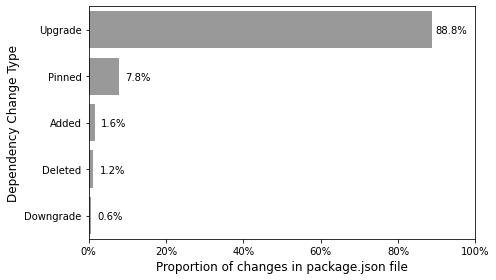

In [67]:
for_plot = (
    (
        gkir_pj_change_types['overall_change_type'].value_counts() / 
        gkir_pj_change_types['overall_change_type'].count()
    ).to_frame(name='proportion')
    .reset_index()
    .rename(columns={'index': 'overall_change_type'})
)
for_plot

def show_values_on_bars(axs, h_v="v", h_offset=0, v_offset=0, val_formatter=int):
    def _show_on_single_plot(ax):
        if h_v == 'v':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = p.get_height()
                ax.text(_x, _y, value, ha='center')
        elif h_v == 'h':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(h_offset)
                _y = p.get_y() + p.get_height() / 2 + float(v_offset)
                value = val_formatter(p.get_width())
                ax.text(_x, _y, value, ha='center')
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
sns.barplot(
    data=for_plot,
    y='overall_change_type',
    x='proportion',
    palette=['0.6'],
    ax=ax,
)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_xlabel('Proportion of changes in package.json file', fontsize=12)

ax.set_ylabel('Dependency Change Type', fontsize=12)
ax.set_yticklabels(['Upgrade', 'Pinned', 'Added', 'Deleted', 'Downgrade'])


format_text = lambda x: f'{round(x*100, 1)}%'
show_values_on_bars(ax, h_v='h', h_offset=0.05, v_offset=0.08, val_formatter=format_text)

save_fig('package_json_change_types')

plt.show()

In [33]:
def show_values_on_bars(axs, h_v="v", scape=0.4):
    def _show_on_single_plot(ax):
        if h_v == 'v':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha='center')
        elif h_v == 'h':
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha='left')
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

Change types to package.json on non-GKIR commits

In [250]:
ngkir_commits_that_change_dep_files_only = (
    ngkir_commits
        .groupby('commit_sha')
        .filter(lambda group: commit_only_changes_files(group, deps_spec_files))
)
# Only package.json changes
ngkir_commits_that_change_dep_files_only__packagejson = (
    ngkir_commits_that_change_dep_files_only[
        ngkir_commits_that_change_dep_files_only['file_name'] == 'package.json'
    ].groupby('commit_sha')
    .first()
    .reset_index()
)
# Merge issue_id
ngkir_commits_that_change_dep_files_only__packagejson = (
    ngkir_commits_that_change_dep_files_only__packagejson.merge(
        commit_to_ngkir_rel[['commit_sha', 'issue_id']],
        on='commit_sha'
    )
)

ngkir_pj_change_types = (
    build_change_types_from_package_json_changes(
        ngkir_commits_that_change_dep_files_only__packagejson
    )
)
ngkir_pj_change_types = ngkir_pj_change_types.drop(columns=['issue_id'])
ngkir_pj_change_types = ngkir_pj_change_types.drop_duplicates()
ngkir_pj_change_types.info()

def get_overall_change_type(row, df):
    matching_rows = df.loc[
        (df['commit_sha'] == row['commit_sha']) &
        (df['package'] == row['package']) &
        (df['changed_from'] == row['changed_from']) &
        (df['changed_to'] == row['changed_to'])
    ]
    if len(matching_rows[matching_rows['change_type'].isin(['pinned'])]):
        return 'pinned'
    return  row['change_type']
    
ngkir_pj_change_types['overall_change_type'] = (
    ngkir_pj_change_types
        .apply(
            lambda row: get_overall_change_type(row, ngkir_pj_change_types),
            axis=1
        )
)
print('Change types on package.json from non-GKIRs')
ngkir_pj_change_types['overall_change_type'].value_counts() / ngkir_pj_change_types['overall_change_type'].count()

error: 1.2.x is not valid SemVer string
error: 9.4.0||^8.9.4 is not valid SemVer string
error: 1.1.1|^2.0.0 is not valid SemVer string
error: 2.49.x is not valid SemVer string
error: 2.49.x is not valid SemVer string
error: 3.1.0||^4.0.0 is not valid SemVer string
error: 1.1.1||^2.0.0 is not valid SemVer string
error: 2.49.x is not valid SemVer string
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 0 to 1384
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   commit_sha    1080 non-null   object
 1   package       1080 non-null   object
 2   changed_from  934 non-null    object
 3   changed_to    981 non-null    object
 4   change_type   1080 non-null   object
dtypes: object(5)
memory usage: 50.6+ KB
Change types on package.json from non-GKIRs


upgrade      0.730556
added        0.135185
deleted      0.091667
downgrade    0.025000
pinned       0.017593
Name: overall_change_type, dtype: float64

<h1>Commits that change other files</h1>

<h3>Comparison of size of changes for GKIR and non-GKIR referenced commits</h3>

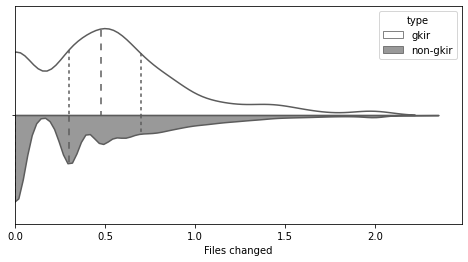

	Mann-Whitney: statistic=16683560.5 pvalue=1.3499840969840782e-11
	Cliff'a Delta: delta=0.12613687956650554 size=negligible
    


In [208]:
gkir_number_of_file_changes = (
    gkir_commits_that_change_other_files
        .groupby('commit_sha')['file_name']
        .count()
        .to_frame(name='files_changed')
        .reset_index()
)
gkir_number_of_file_changes['type'] = 'gkir'
nkir_number_of_file_changes = (
    ngkir_commits_that_change_other_files
        .groupby('commit_sha')['file_name']
        .count()
        .to_frame(name='files_changed')
        .reset_index()
)
nkir_number_of_file_changes['type'] = 'non-gkir'

number_of_file_changes = gkir_number_of_file_changes.append(nkir_number_of_file_changes)
number_of_file_changes['log_files_changed'] = np.log10(number_of_file_changes['files_changed'])
number_of_file_changes['placeholder'] = ''

for_plot = filter_outliers(df=number_of_file_changes, col='files_changed')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
sns.violinplot(
    data=for_plot,
    x='log_files_changed',
    y='placeholder',
    hue='type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
    scale='width',
)
ax.set_xlabel('Files changed')
ax.set_ylabel('')
ax.set_xlim(0,None)

# def format_log_exp(value):
#     table = ['\u2070', '\u2071', '\u00B2', '\u00B3', '\u2074', '\u2075', '\u2076', '\u2077', '\u2078', '\u2079']
#     if value >= 0:
#         return f'$10{table[int(value)]}$'
#     else:
#         return f'$10\u207B{table[abs(int(value))]}$'

# log10_int_func_formatter = FuncFormatter(lambda x, pos: format_log_exp_int(x))
# ax.xaxis.set_major_formatter(log10_int_func_formatter)
# L = plt.legend(
#     loc='upper center',
#     fontsize='small',
#     fancybox=True,
#     bbox_to_anchor=(0.5,1.11),
#     ncol=2
# )

# L.get_texts()[0].set_text('Additions')
# L.get_texts()[1].set_text('Deletions')

# save_fig('most_common_file_code_churn')

plt.show()

mannwhitneyu_cliffsdelta(
    number_of_file_changes[number_of_file_changes['type'] == 'gkir']['files_changed'],
    number_of_file_changes[number_of_file_changes['type'] == 'non-gkir']['files_changed']
)
